# Cancer Classification

In [1]:
import jax.numpy as np
import numpy as onp
import jax
from matplotlib import pyplot as plt
import pandas as pd
from jax.lib import xla_bridge
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import  train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import seaborn as sns
import ADAMLL as ada
from ADAMLL.activations import sigmoid, relu, eye


print("jax backend {}".format(xla_bridge.get_backend().platform))

key = jax.random.PRNGKey(2024)

jax backend gpu


## Data

In [2]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)

print("X_train shape {}".format(X_train.shape))
print("y_train shape {}".format(y_train.shape))
print("X_test shape {}".format(X_test.shape))
print("y_test shape {}".format(y_test.shape))





X_train shape (426, 30)
y_train shape (426, 1)
X_test shape (143, 30)
y_test shape (143, 1)


### Plot data


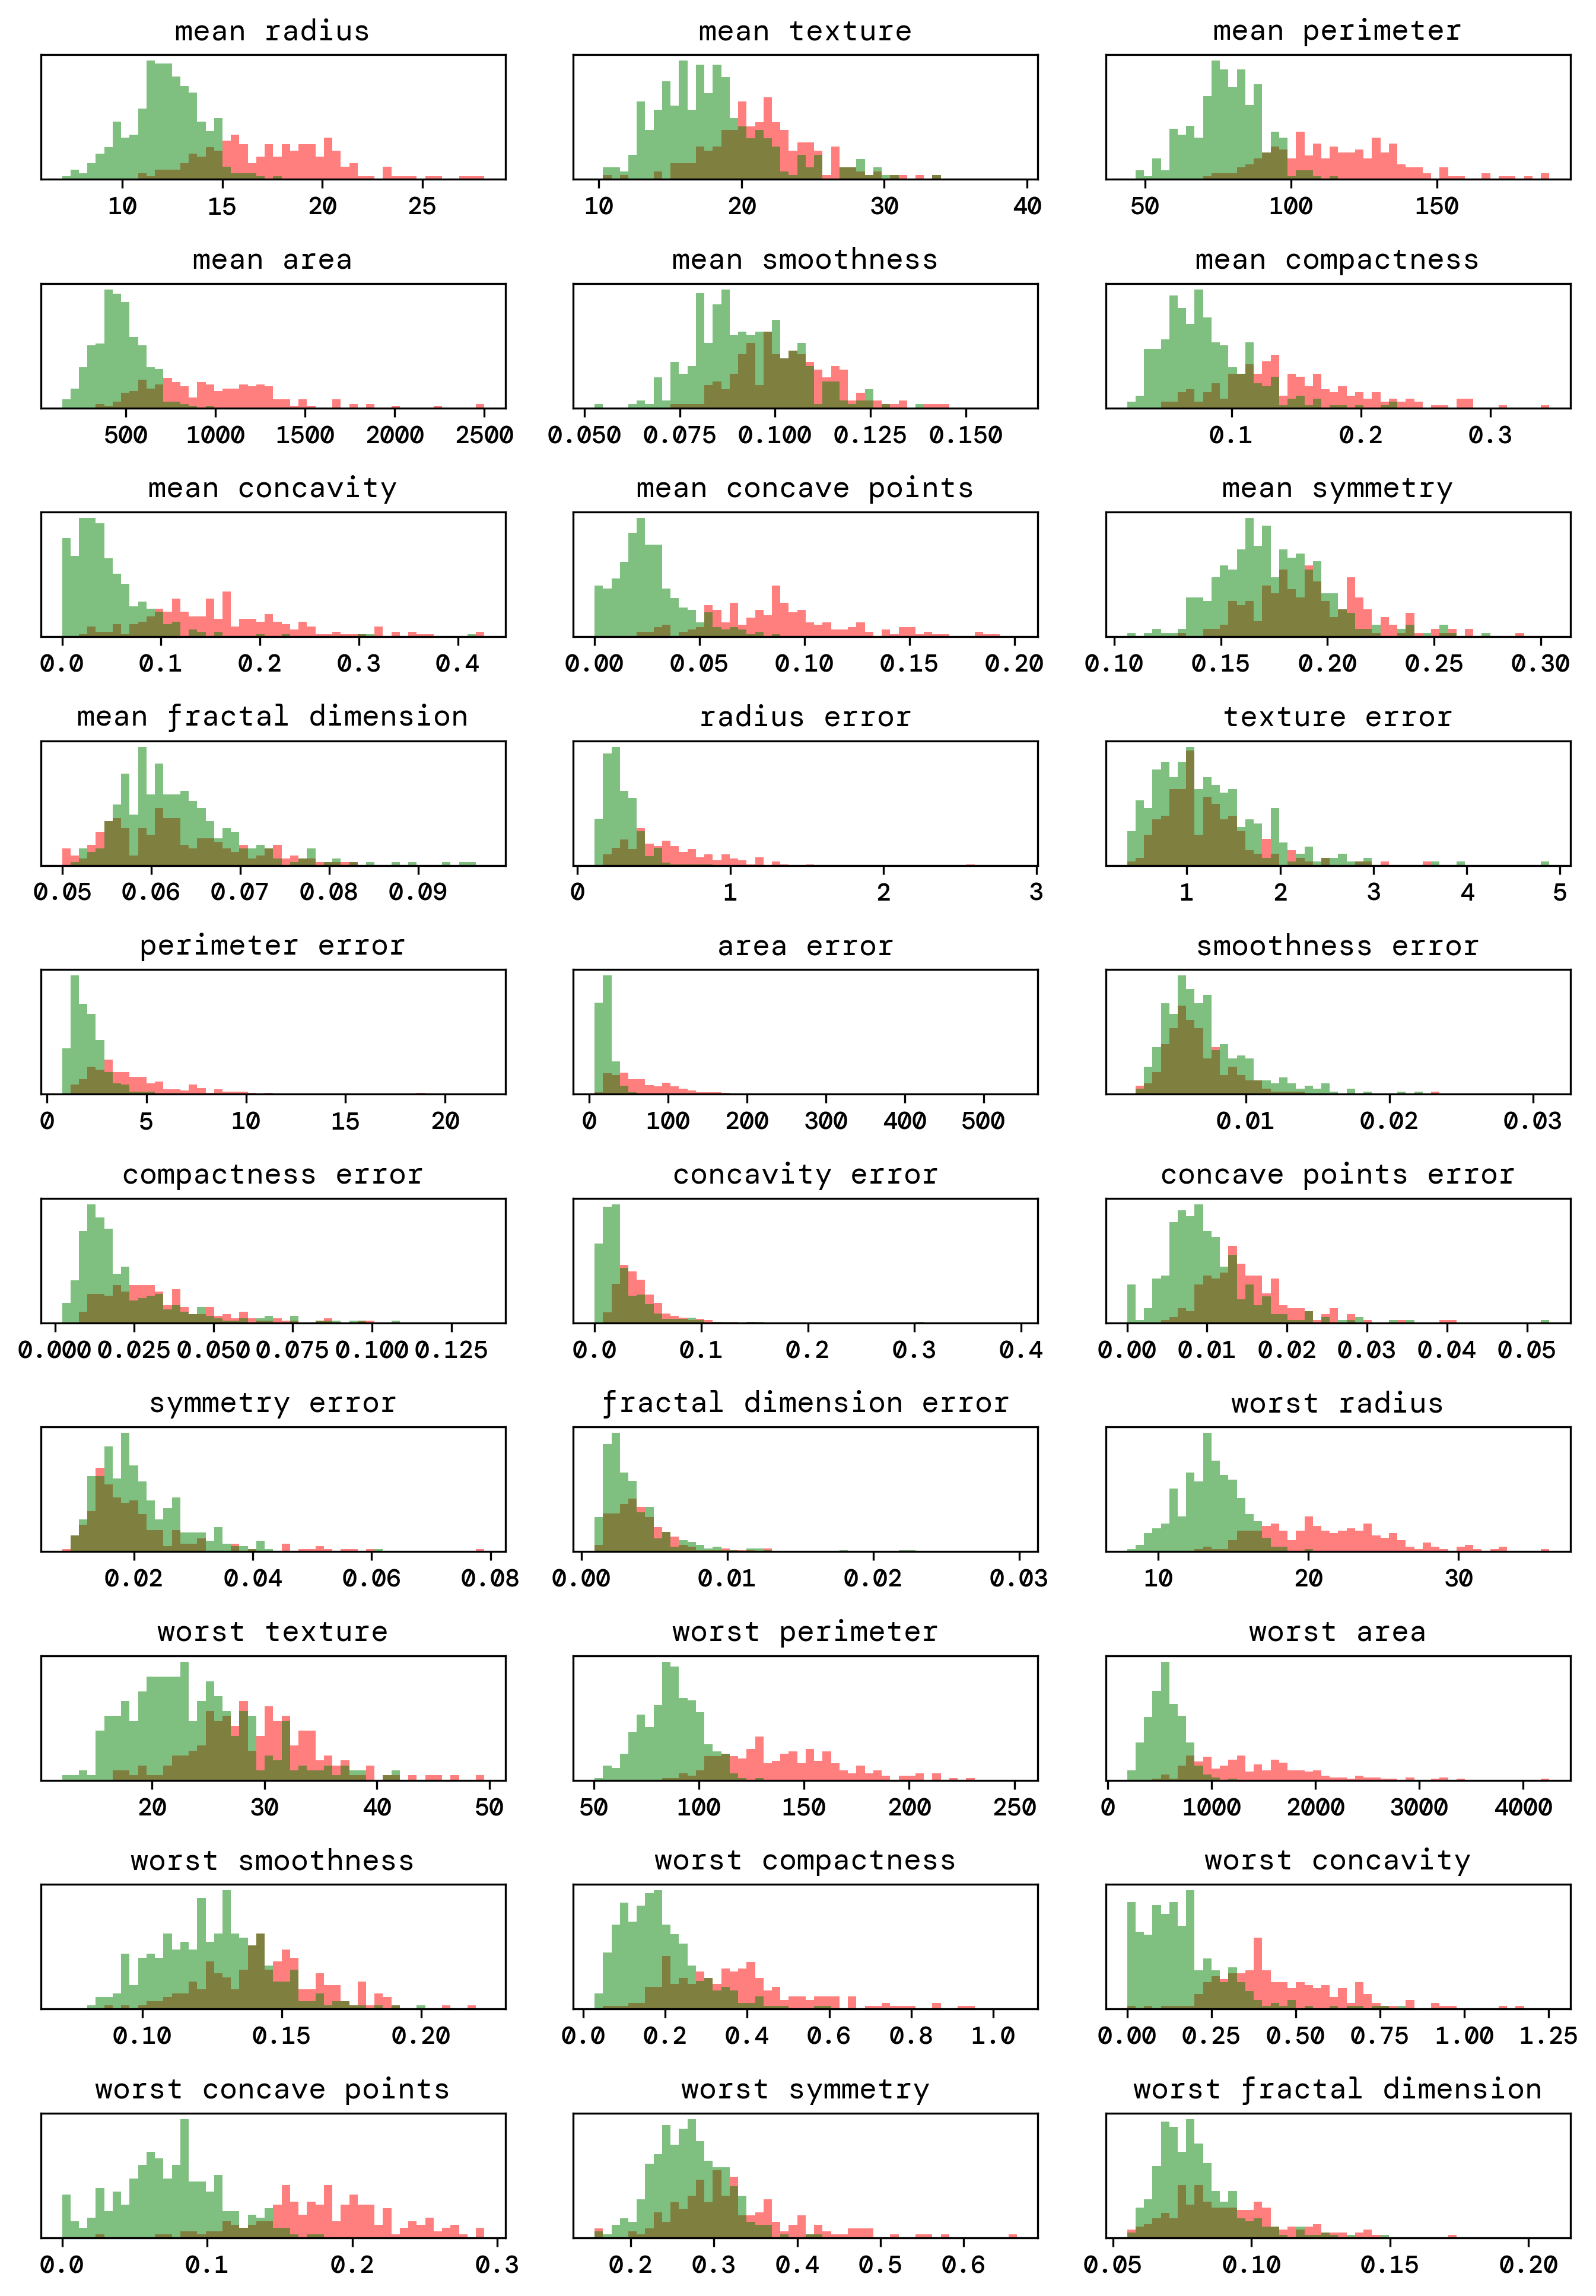

In [3]:
fig, axes = plt.subplots(10,3, figsize=(9, 13))
malignant = cancer.data[cancer.target==0]
benign = cancer.data[cancer.target==1]
print("malignent shape: ",malignant.shape)
print("benign shape: ",benign.shape)
ax = axes.ravel()
for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color='r', alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color='g', alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
fig.tight_layout()
plt.savefig("../runsAndFigures/feature_histogram.png",bbox_inches='tight')
plt.show()

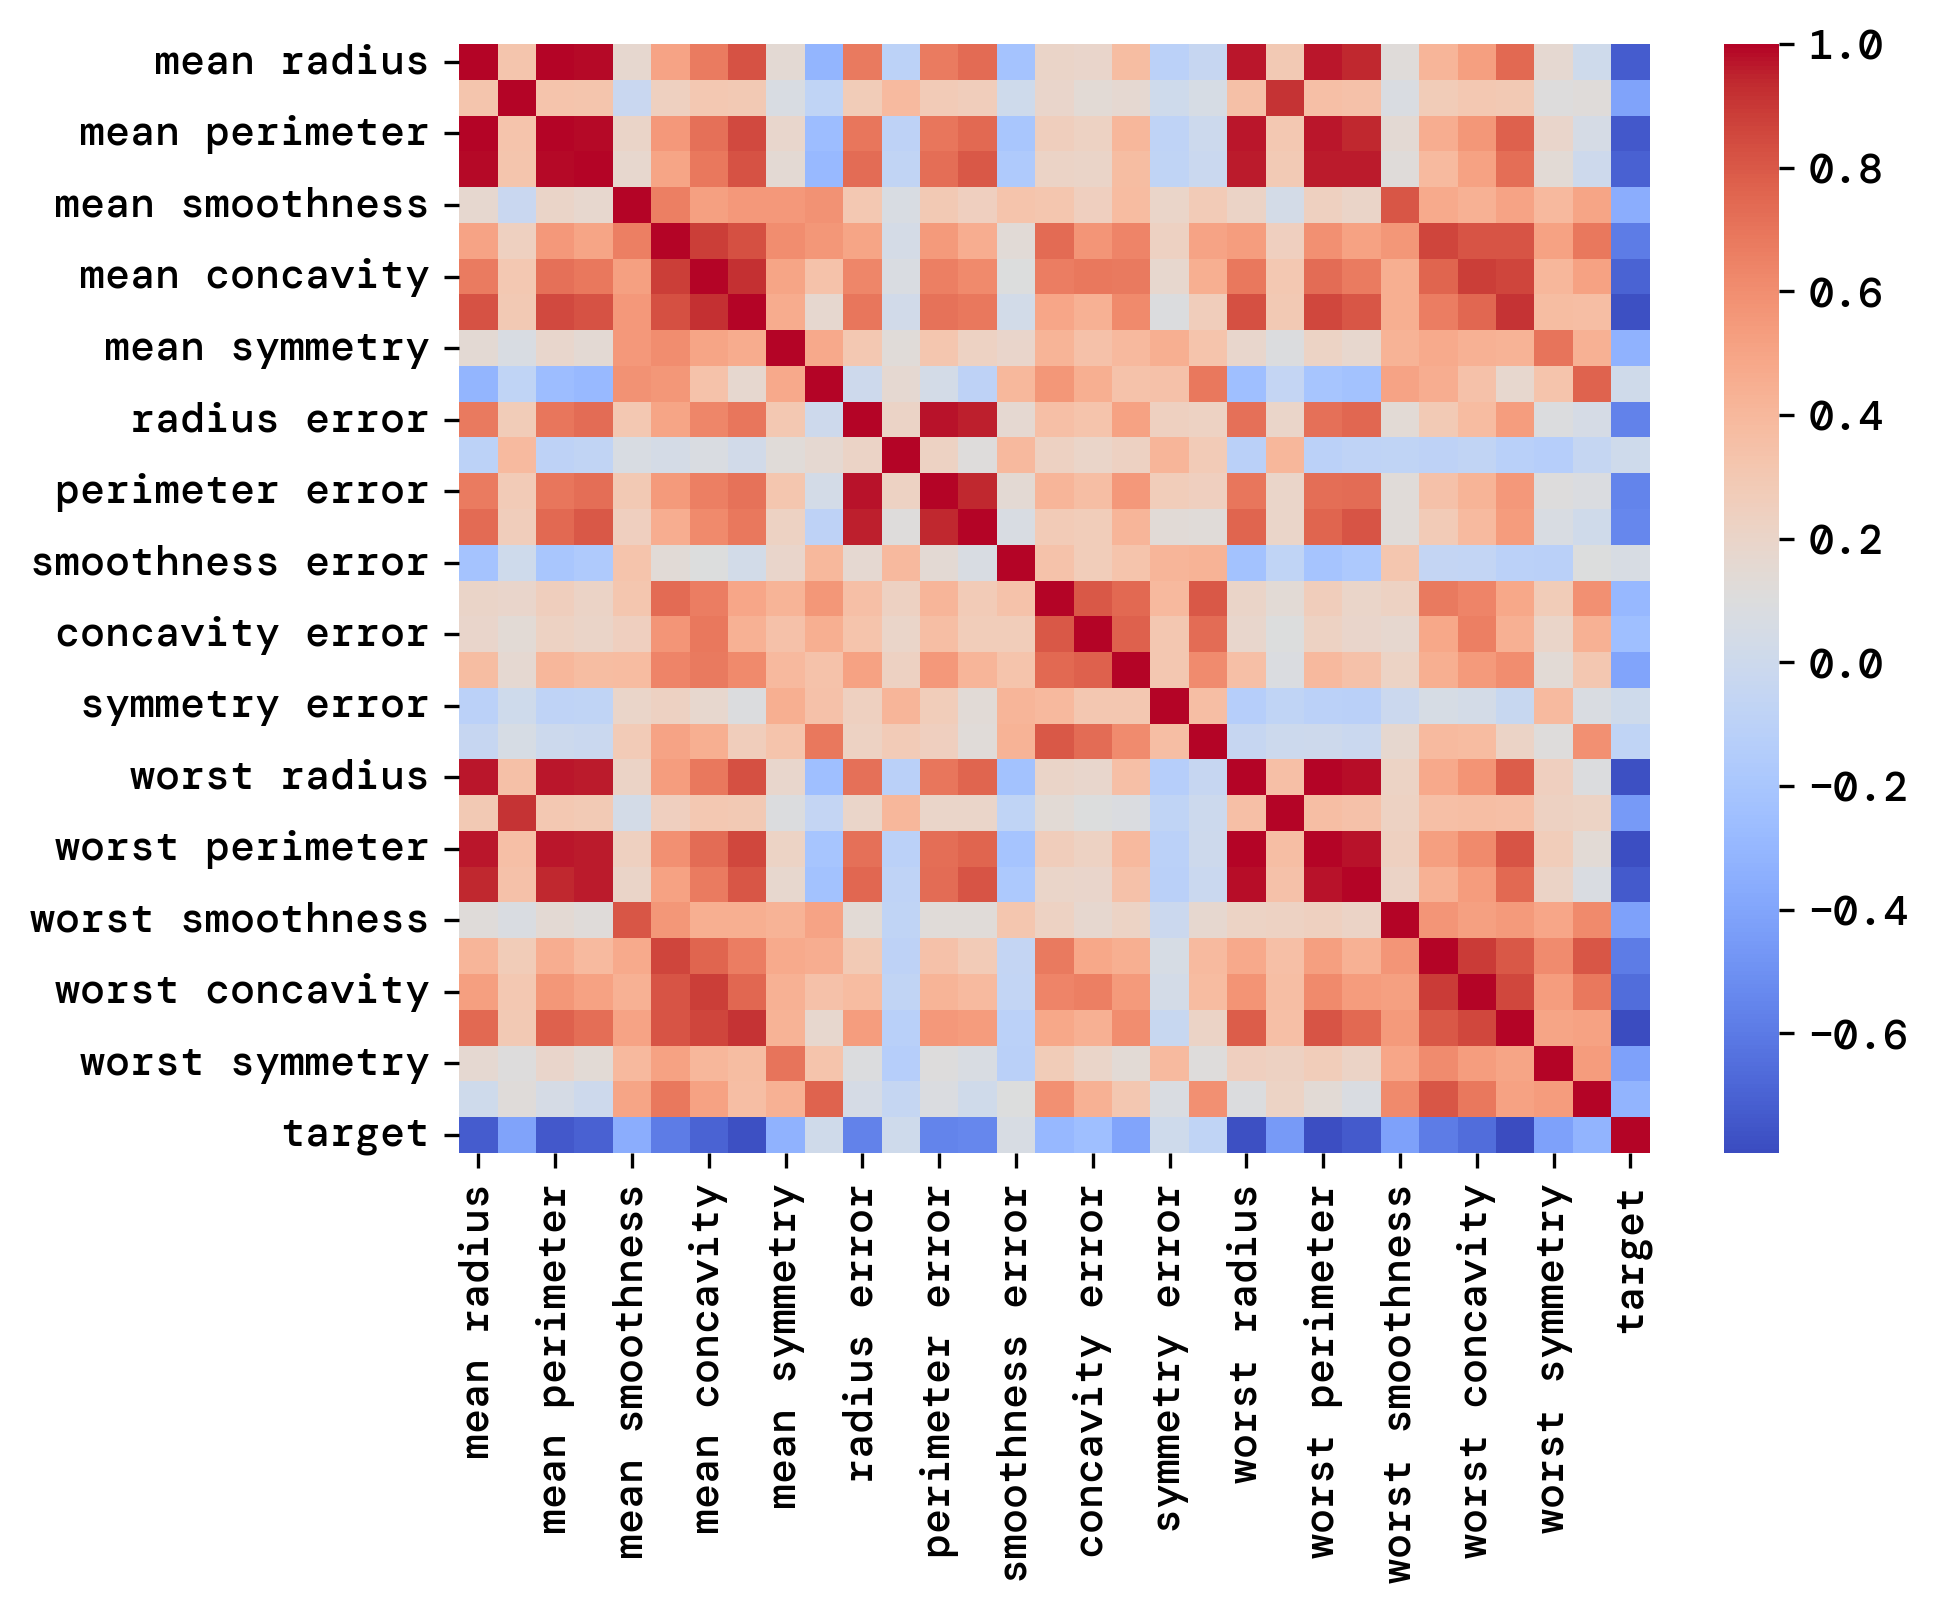

In [4]:
# correlation matrix
cancer_df = pd.DataFrame(cancer.data,columns=cancer.feature_names)
cancer_df["target"] = cancer.target
corr = cancer_df.corr()
plt.figure()
sns.heatmap(corr,cmap="coolwarm")
plt.savefig("../runsAndFigures/feature_correlation.png",bbox_inches='tight')
plt.show()

## Feature Selection

In [5]:

#Select features relevant to classification (texture,perimeter,compactness and symmetery) 
#and add to input matrix


# temp1=np.reshape(x[:,1],(len(x[:,1]),1))
# temp2=np.reshape(x[:,2],(len(x[:,2]),1))
# X=np.hstack((temp1,temp2))      
# temp=np.reshape(x[:,5],(len(x[:,5]),1))
# X=np.hstack((X,temp))       
# temp=np.reshape(x[:,8],(len(x[:,8]),1))
# X=np.hstack((X,temp))       

# X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2) #Split data into training and test sets

# y_train=to_categorical(y_train)     #Convert labels to categorical when using categorical cross entropy
# y_test=to_categorical(y_test)

# del temp1,temp2,temp

# Analysis

In [14]:

# Define tunable parameters"

etas=[0.1, 0.01, 0.001, 0.0001]             # 0.1 works well 
lamdas = [0.1, 0.01, 0.001, 0.0001]         # 0.1 works well 
n_epoch=[100, 200, 300, 400, 500]           # 100 works well
n_neuron=np.logspace(0,3,4,dtype=int)       # 10 works well
n_hidden_layers=[1,2,3,4]                                  #
batch_size=100
tol = 0.001

# optimizer parameters
gammas = [0.1, 0.5, 0.9, 0.99]              # 0.9 works well
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

kfold = KFold(n_splits=8)

def cross_val(X_train, y_train, X_test, y_test, model, kfold):
    k = 0
    score = onp.zeros(kfold.n_splits)
    for train_ind, test_ind in kfold.split(X_train):
        model.fit(X_train[train_ind], y_train[train_ind])
        score[k] = ada.accuracy(model.classify(X_train[test_ind]), y_train[test_ind])
        k += 1
    return score.mean(), score.std()



### Momentum and learning rate

Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [---->               ] 25%
Training stopped after 199 epochs                                     Progress: [--------->          ] 50%
Training stopped after 199 epochs                                     Progress: [-------------->     ] 75%
Training stopped after 199 epochs                                     

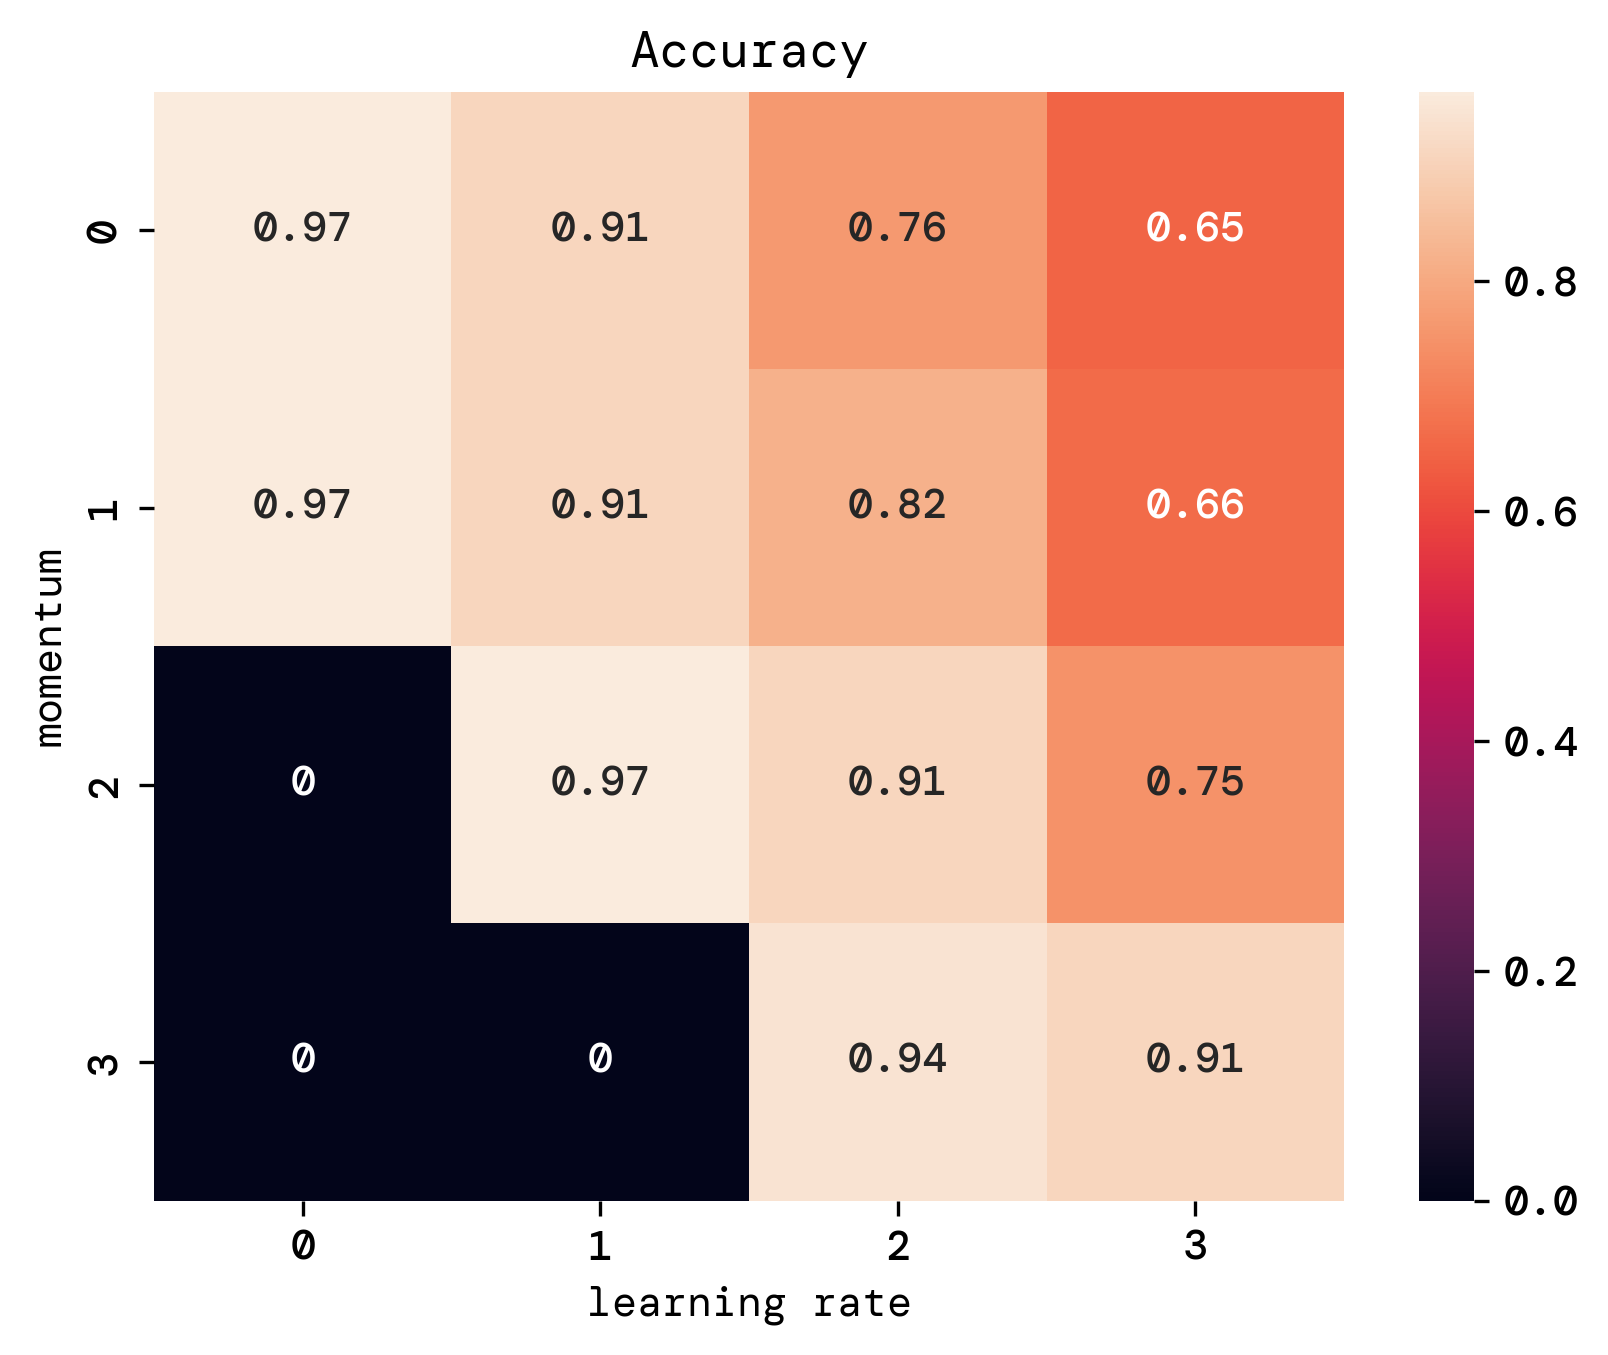

In [21]:
gamma_eta = onp.zeros((len(gammas), len(etas))) 

for i, gamma in enumerate(gammas):
    print(ada.progress_bar(i, len(gammas)))
    for j, eta in enumerate(etas):
        network = ada.NN.Model([[1, sigmoid]], eta,200,tol, 'sgd', 0, gamma, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
        network.fit(X_train, y_train)
        gamma_eta[i,j] = ada.accuracy(network.classify(X_test), y_test)


ax = sns.heatmap(gamma_eta, annot=True)
plt.title("Accuracy")
plt.xlabel("learning rate")
plt.ylabel("momentum")
plt.savefig("../runsAndFigures/accuracy_lr_gamma.png",bbox_inches='tight')
plt.show()

### Lambda and epochs

Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [---->               ] 25%
Training stopped after 199 epochs                                     Progress: [--------->          ] 50%
Training stopped after 199 epochs                                     Progress: [-------------->     ] 75%
Training stopped after 199 epochs                                     

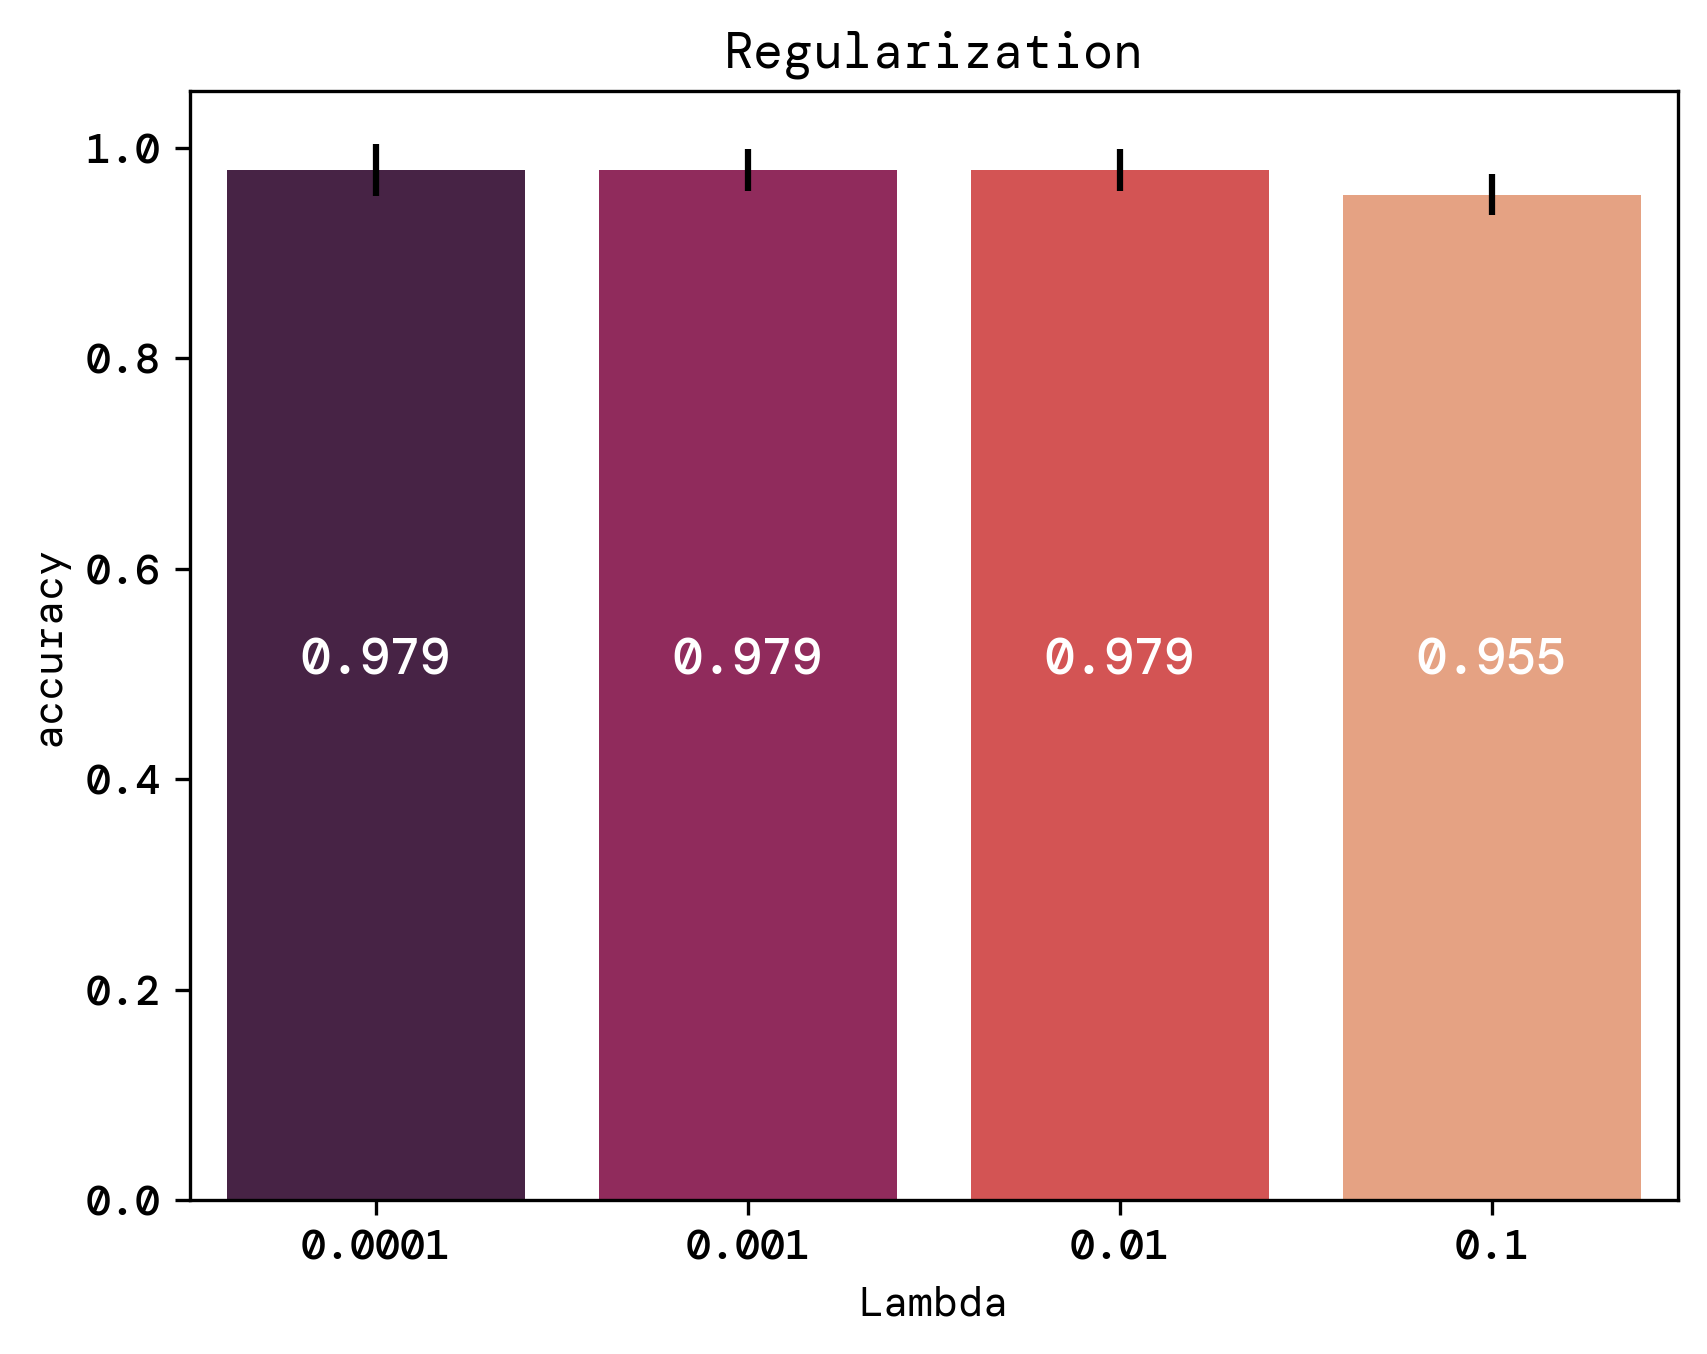

In [18]:
alphas = onp.zeros((len(lamdas),2))

for i, lamda in enumerate(lamdas):
    print(ada.progress_bar(i, len(lamdas)))
    network = ada.NN.Model([[1, sigmoid]], 0.01, 200,tol, 'sgd', lamda, 0.9, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
    mean, var = cross_val(X_train, y_train, X_test, y_test, network, kfold)
    alphas[i,0] = mean
    alphas[i,1] = var


ax = sns.barplot(x=lamdas, y=alphas[:,0], yerr=alphas[:,1], palette="rocket")
ax.set_xlabel("Lambda")
plt.title("Regularization")
plt.ylabel("accuracy")
ax.text(0, 0.5, f"{alphas[3,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.5, f"{alphas[2,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.5, f"{alphas[1,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.5, f"{alphas[0,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/accuracy_alpha.png",bbox_inches='tight')
plt.show()

### Adam vs RMSProp vs AdaGrad

Training stopped after 99 epochs                                      

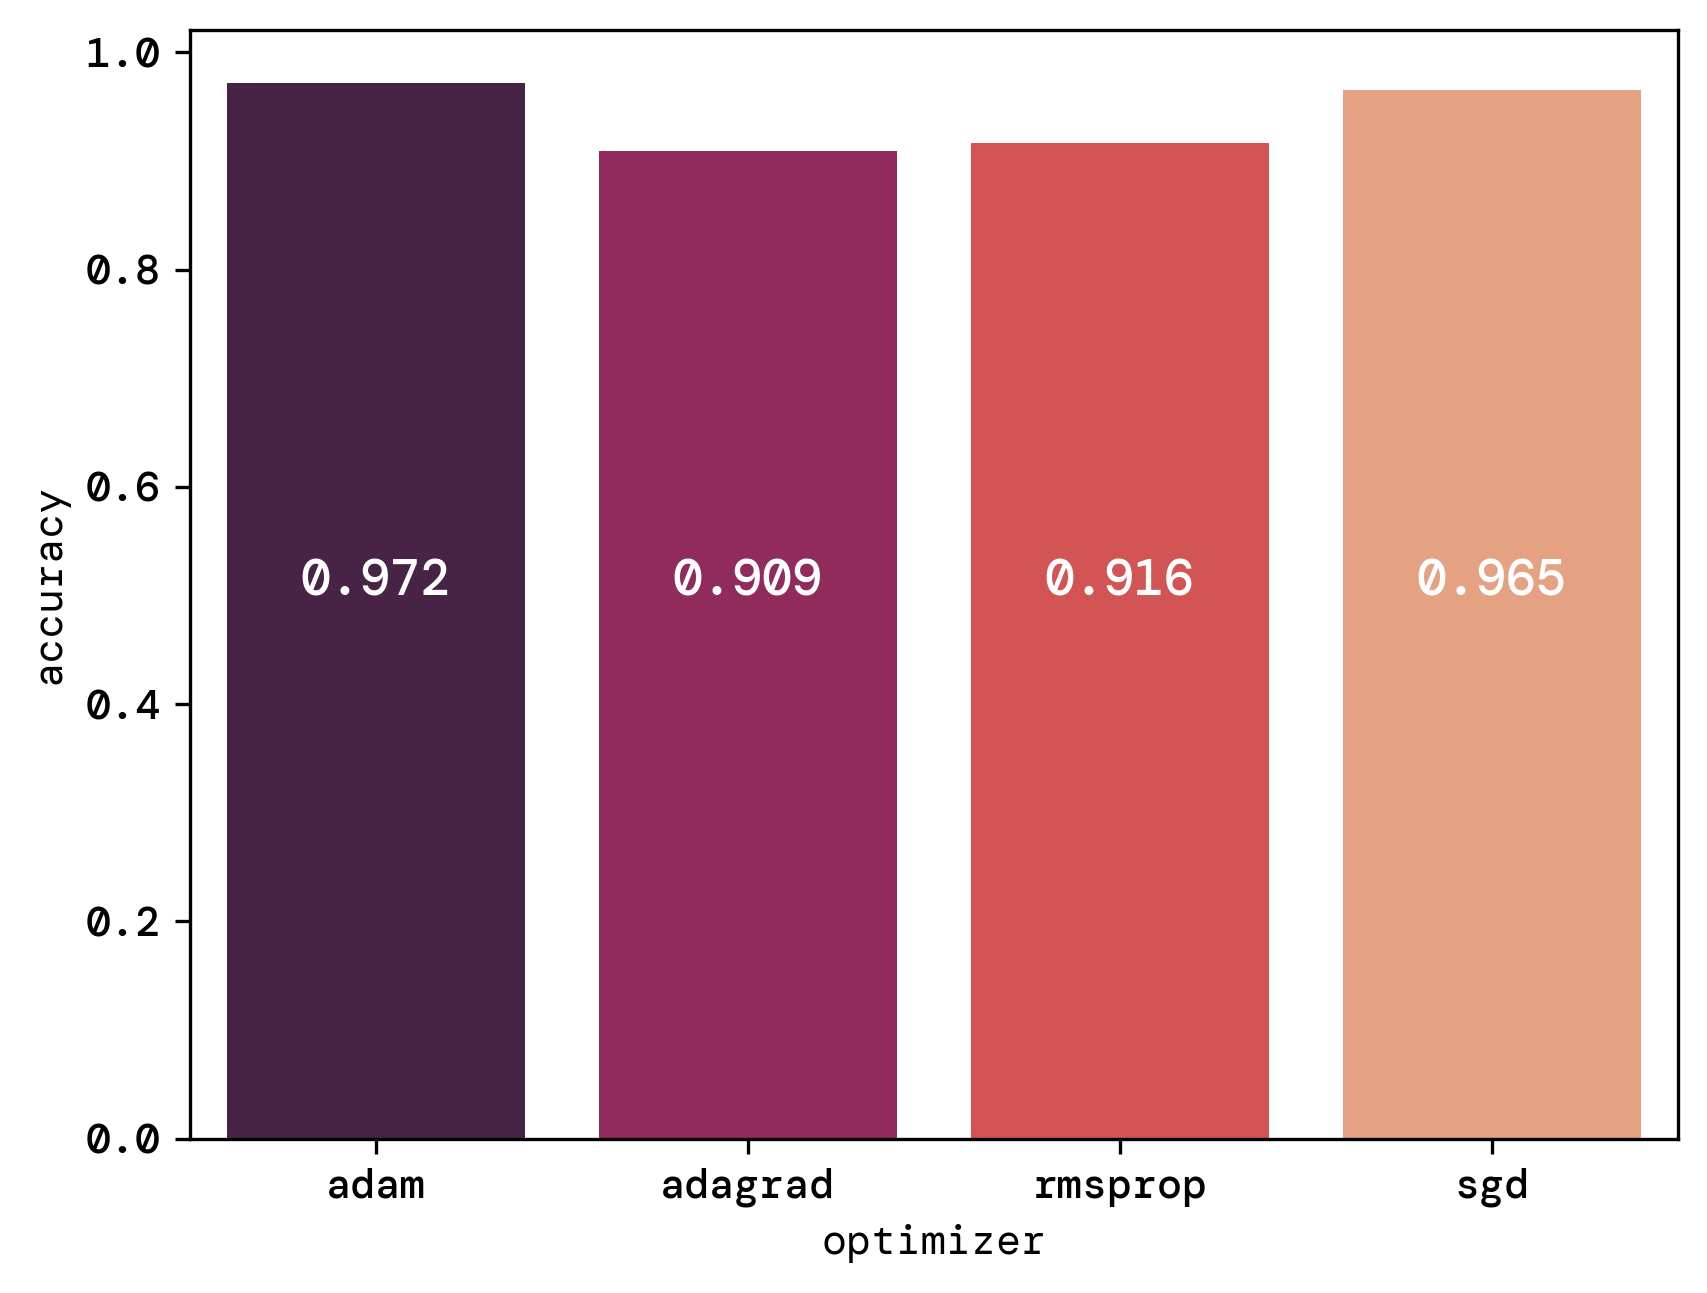

In [16]:

network = ada.NN.Model([[1, sigmoid]], 0.01 , 100 ,tol, 'adam', 0.0001 , 0.9, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
network.fit(X_train,y_train, X_test, y_test, batch_size=batch_size)
adam_accuracy = ada.accuracy(network.classify(X_test), y_test)
network = ada.NN.Model([[1, sigmoid]], 0.01 , 100 ,tol, 'adagrad', 0.0001 , 0.9, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
network.fit(X_train,y_train, X_test, y_test, batch_size=batch_size)
adagrad_accuracy = ada.accuracy(network.classify(X_test), y_test)
network = ada.NN.Model([[1, sigmoid]], 0.01 , 100 ,tol, 'rmsprop', 0.0001 , 0.9, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
network.fit(X_train,y_train, X_test, y_test, batch_size=batch_size)
rmsprop_accuracy = ada.accuracy(network.classify(X_test), y_test)
network = ada.NN.Model([[1, sigmoid]], 0.01 , 100 ,tol, 'sgd', 0.0001 , 0.9, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
network.fit(X_train,y_train, X_test, y_test, batch_size=batch_size)
sgd_accuracy = ada.accuracy(network.classify(X_test), y_test)



optimizer_accuracy = onp.array([adam_accuracy, adagrad_accuracy, rmsprop_accuracy, sgd_accuracy])
adam_accuracy = np.round(adam_accuracy, 3)
rmsprop_accuracy = np.round(rmsprop_accuracy, 3)
adagrad_accuracy = np.round(adagrad_accuracy, 3)
sgd_accuracy = np.round(sgd_accuracy, 3)
optimizer_names = ['adam', 'adagrad', 'rmsprop', 'sgd']
ax = sns.barplot(x=optimizer_names, y=optimizer_accuracy, palette="rocket")
ax.set_xlabel("optimizer")
ax.set_ylabel("accuracy")
ax.text(0, 0.5, f"{adam_accuracy:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.5, f"{adagrad_accuracy:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.5, f"{rmsprop_accuracy:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.5, f"{sgd_accuracy:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/optimizer_accuracy.png",bbox_inches='tight')
plt.show()


## Multiple layers

## Comparing with TensorFlow

5/5 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.3706


5/5 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.3706


5/5 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.3706


5/5 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.3706


TypeError: object of type 'float' has no len()

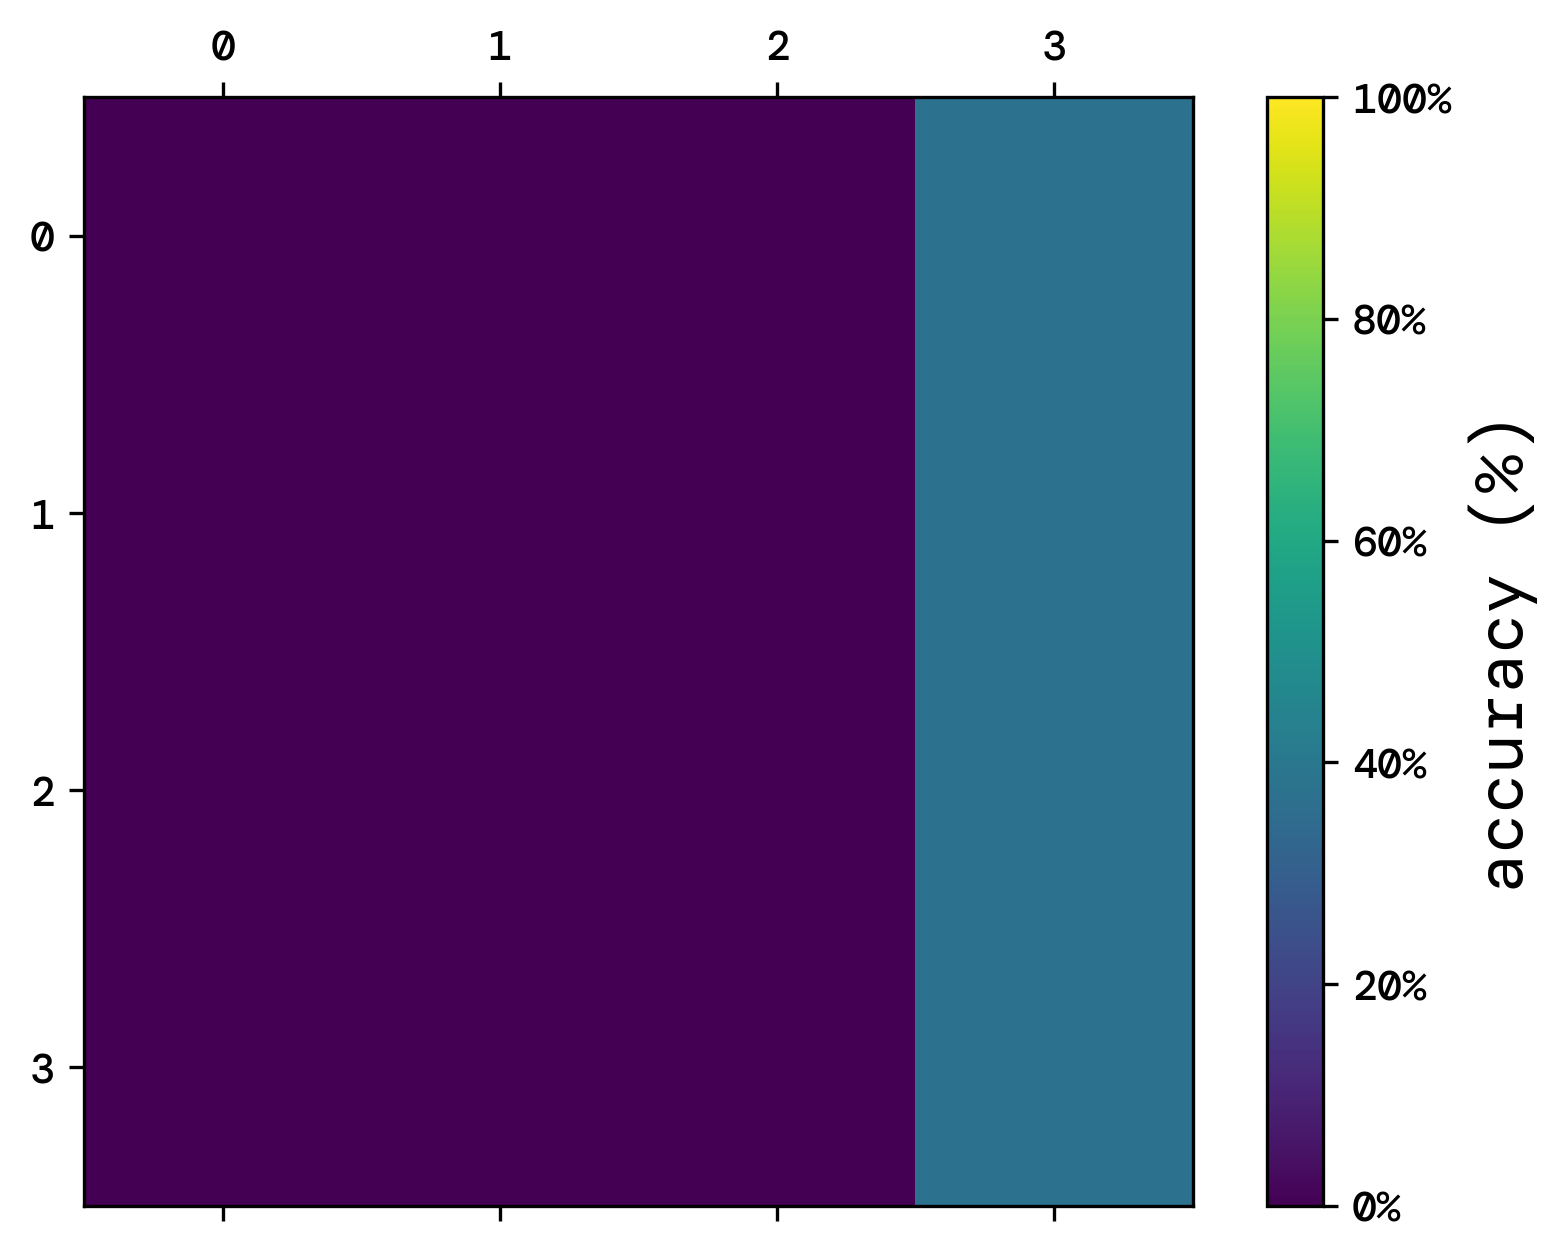

In [ ]:
#Copied from the fys-stk4155 repository: https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week42.html#the-breast-cancer-data-now-with-keras
import numpy as onp
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
import pickle
import os 

X_train = onp.asarray(X_train)
X_test = onp.asarray(X_test)
y_train = onp.asarray(y_train).reshape(-1,1)
y_test = onp.asarray(y_test).reshape(-1,1)

                      #Number of samples per gradient update



"""Define function to return Deep Neural Network model"""

def NN_model(inputsize,n_layers,n_neuron,eta,lamda):
    model=Sequential()      
    for i in range(n_layers):       #Run loop to add hidden layers to the model
        if (i==0):                  #First layer requires input dimensions
            model.add(Dense(n_neuron,activation='relu',kernel_regularizer=regularizers.l2(lamda),input_dim=inputsize))
        else:                       #Subsequent layers are capable of automatic shape inferencing
            model.add(Dense(n_neuron,activation='relu',kernel_regularizer=regularizers.l2(lamda)))
    model.add(Dense(1,activation='sigmoid'))  #2 outputs - ordered and disordered (softmax for prob)
    sgd=optimizers.SGD(lr=eta)
    model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
    return model

    
Train_accuracy=onp.zeros((len(n_neuron),len(etas)))      #Define matrices to store accuracy scores as a function
Test_accuracy=onp.zeros((len(n_neuron),len(etas)))       #of learning rate and number of hidden neurons for 

for i in range(len(n_neuron)):     #run loops over hidden neurons and learning rates to calculate 
    DNN_model=NN_model(X_train.shape[1],2,n_neuron[i],0.01, 0.0001)
    DNN_model.fit(X_train,y_train,epochs=100,batch_size=batch_size,verbose=0)
    Train_accuracy[i,j]=DNN_model.evaluate(X_train,y_train)[1]
    Test_accuracy[i,j]=DNN_model.evaluate(X_test,y_test)[1]
               

def plot_data(x,y,data,title=None):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)
    if title is not None:
        ax.set_title(title)

    plt.tight_layout()

    plt.show()
    
plot_data(eta,n_neuron,Train_accuracy, 'training')
plot_data(eta,n_neuron,Test_accuracy, 'testing')

## Comparing with SKLearn

In [ ]:
#Copied from the fys-stk4155 repository: https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter4.html
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
#now scale the data
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))